### Notebook to be used to test that ATCamera, ATHeaderService and ATArchiver are online and working

In [1]:
import numpy as np
from lsst.ts import salobj
import asyncio
from astropy.io import fits

import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter
from matplotlib import pyplot as plt
from astropy import time as astropytime
#%matplotlib ipympl
plt.rcParams['figure.figsize'] = [7, 6]

import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.afw.display as afwDisplay

afwDisplay.setDefaultBackend('matplotlib')
import time
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.geom

import os
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
logger = logging.getLogger('image_display_notebook')

In [2]:
# Want to display in firefly?
afwDisplay.setDefaultBackend('firefly')
os.environ['FIREFLY_HTML'] = "slate.html"
os.environ['FIREFLY_URL'] = 'http://139.229.170.210:8080/firefly/'

In [3]:
# # Setup the butler
#accs_images = True
accs_images = False
if accs_images:
    repo = os.path.join("/home/saluser/ingest/accs/")#, mapper={'calibRoot': "/home/saluser/ingest/dmcs/CALIB"})
    butler = dafPersist.Butler(repo)
else:
    #repo = os.path.join("/home/saluser/ingest/dmcs/")#, mapper={'calibRoot': "/home/saluser/ingest/dmcs/CALIB"})
    repo = os.path.join("/project/shared/auxTel/")
    butler = dafPersist.Butler(repo) #
    #butler = dafPersist.Butler(repo, mapper="lsst.obs.lsst.auxTel.AuxTelMapper")
#test   
#raw = butler.get("raw", visit=2019111300004)
#image = raw.getImage().array

In [19]:
visitID = 2020031600132 #292
print(visitID)


2020031600132


In [20]:
from lsst.rapid.analysis.bestEffort import BestEffortIsr
REPODIR = '/project/shared/auxTel/'
bestEffort = BestEffortIsr(REPODIR)
isr_corr_exposure = bestEffort.getExposure(visitID)

2020-03-17 02:22:40,046 lsst.obs.lsst.translators.latiss WARNING  AT_O_20200316_000132: Dark time less than exposure time. Setting dark time to the exposure time.


Caught 'LatissMapper' object has no attribute 'map_linearizer' - update your mapper?
Running best effort isr...
Running with bias subtraction
Running with dark correction subtraction
Running with defect correction
Running cosmic ray repair


In [21]:
plt.close('all')
disp = afwDisplay.Display(2, reopenPlot=True, verbose=True)

Opening firefly device 2
virtual[2]._setImageColormap(cmap="gray")


In [22]:
if True: # display the image in firefly
    #plt.close('all')
    #disp = afwDisplay.Display(2, reopenPlot=True)
    disp.setMaskPlaneColor('SAT', afwDisplay.IGNORE)
    disp.setImageColormap('gray')
    disp.scale('linear', 'zscale')
    disp.mtv(isr_corr_exposure, title='visit = {}'.format(visitID))
    #cgUtils.overlayCcdBoxes(isr_corr_exposure.getDetector(), isTrimmed=True, display=disp)

virtual[2]._setImageColormap(cmap="gray")
displaying image
region layer id is lsstRegions2
displaying mask


In [23]:
# Only here for me to debug, should be up top with other declarations
import importlib
import utils.findNarrowbandRonchiPeaks
importlib.reload(utils.findNarrowbandRonchiPeaks)
from utils.findNarrowbandRonchiPeaks import findNarrowbandRonchiPeaks

import utils.fitExposure
importlib.reload(utils.fitExposure)
from utils.fitExposure import fit2DGaussian

import utils.calc_CofM
importlib.reload(utils.calc_CofM)
from utils.calc_CofM import calc_CofM

import utils.calc_encircled_energy
importlib.reload(utils.calc_encircled_energy)
from utils.calc_encircled_energy import calc_encircled_energy

import utils.findBrightestSourceInBox
importlib.reload(utils.findBrightestSourceInBox)
from utils.findBrightestSourceInBox import findBrightestSourceInBox

In [24]:
isr_corr_exposure.image.array -= np.median(isr_corr_exposure.image.array)

In [25]:
# Source detection libraries
from lsst.meas.algorithms.detection import SourceDetectionTask
import lsst.afw.table as afwTable

# create the output table for source detection
schema = afwTable.SourceTable.makeMinimalSchema()
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 20  # detection threshold after smoothing
# config.nSigmaToGrow = 1.2 # Only for doughnuts

sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)
tab = afwTable.SourceTable.make(schema)
result = sourceDetectionTask.run(tab, isr_corr_exposure, sigma=5.1)

In [26]:
#result.sources

## Fit a gaussian

<Gaussian2D(amplitude=7349.55051835, x_mean=1369.56902075, y_mean=2533.40723208, x_stddev=4.97309268, y_stddev=5.01551975, theta=0.)>
Visit ID = 2020031600132


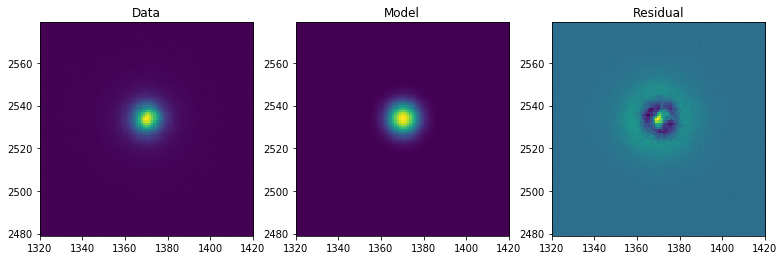

In [27]:
# Find 0th and +/- 1 order peaks 
sources = result.sources
zeroth_order_estimate = lsst.geom.Point2D(2132,2308)
zeroth_order_estimate = lsst.geom.Point2D(1369, 2528)
#zeroth_order_estimate = lsst.geom.Point2D(2250,1500)
zeroth_order_star_BBox= lsst.geom.Box2I.makeCenteredBox(zeroth_order_estimate, lsst.geom.Extent2I(400,400)) 
bbox0 = lsst.geom.Box2I.makeCenteredBox(zeroth_order_estimate, lsst.geom.Extent2I(100,100)) 
wavelength= 677.0 
dispersion =  0 #(1/0.6358) # pixels/nm
spectral_position_angle= 0.0107 # radians clockwise from top
#center_source, peak1, peak2 = findNarrowbandRonchiPeaks(sources, zeroth_order_star_BBox, wavelength, dispersion, spectral_position_angle)

center_source, center_peak = findBrightestSourceInBox(sources, zeroth_order_star_BBox)

peak0_subim = isr_corr_exposure.subset(bbox0)
p0, x0 , y0 = fit2DGaussian(peak0_subim, plot=True)
print('Visit ID = {}'.format(visitID))

In [28]:
seeing = p0.x_fwhm

In [29]:
print(p0.x_fwhm*0.101)
print(p0.y_fwhm*0.101)

1.1827845708738842
1.1928752901053694


In [31]:
# peak0_subim = isr_corr_exposure.subset(bbox0)
# p0, x0 , y0 = fit2DGaussian(peak0_subim, plot=True)

In [87]:

# # Fit peaks
# # zeroth order
# # variables names are weird here because I can't think of a clever way to have -1 and +1 as variable names

# #bbox0 = lsst.geom.Box2I.makeCenteredBox(center_source.getFootprint().getCentroid(), lsst.geom.Extent2I(100,100)) 

# print('visitID is: {}'.format(visitID))
# zeroth_order_estimate = lsst.geom.Point2D(1630,1330)
# #zeroth_order_estimate = lsst.geom.Point2D(2025,1980)
# bbox0 = lsst.geom.Box2I.makeCenteredBox(zeroth_order_estimate, lsst.geom.Extent2I(100,100)) 

# peak0_subim = isr_corr_exposure.subset(bbox0)
# p0, x0 , y0 = fit2DGaussian(peak0_subim, plot=True)


In [32]:
p0_x_CofM, p0_y_CofM = calc_CofM(peak0_subim) # 2167,3372

# Calculate EE and CofM
p0_EE_rad50_pix, p0_EE_rad67_pix, p0_EE_rad80_pix = calc_encircled_energy(peak0_subim, plot=True) 
fit_data.append(p0_EE_rad80_pix)

NameError: name 'peak0_subim' is not defined